In [ ]:
!pip install rasterio

In [ ]:

!pip install earthpy gdal

# Import Modules

In [ ]:
from glob import glob
import numpy as np
from scipy.io import loadmat
from PIL import Image
from skimage.io import imread
from numpy import asarray
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
from rasterio import plot
import earthpy.plot as ep
import scipy.io


# Read Data 

Read the 10 bands using rasterio and stack them into an n-dimensional array using numpy.stack() method.

In [ ]:
dataset = rasterio.open("/content/drive/MyDrive/sat_images/places/Zurich_District_Zurich_Zurich_Switzer_8.339246_47.276434__8.77791__47.507616/sentinel2_image_cropped.tif")


# Visualize the bands

Data have multiple numbers of bands that contain the data ranging from visible to infrared. 

In [ ]:
band1=dataset.read(1)
band2=dataset.read(2)
band3=dataset.read(3)
band4=dataset.read(4)
band5=dataset.read(5)
band6=dataset.read(6)
band7=dataset.read(7)
band8=dataset.read(8)
band9=dataset.read(9)
band10=dataset.read(10)


In [ ]:
l = [band1,band2,band3,band4,band5,band6,band7,band8,band9,band10]
arr_st = np.stack(l)
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 1975
Width: 3744
Bands: 10


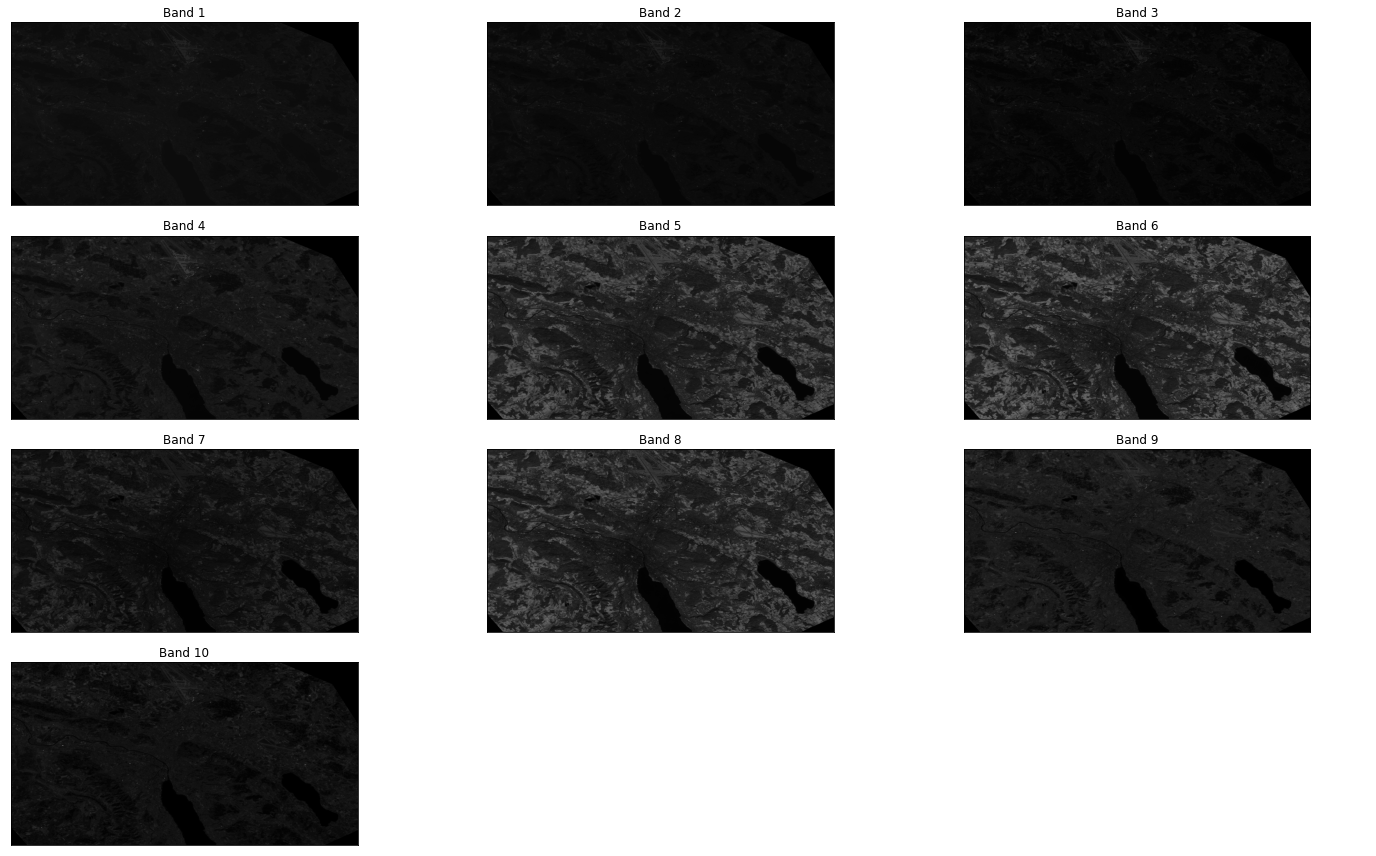

In [ ]:
ep.plot_bands(arr_st, figsize = (20, 12), cols = 3 , cbar = False)
plt.show()

# RGB Composite Image

Plot the red, green, and blue bands, which are bands 4, 3, and 2, respectively.(remember 0 index)

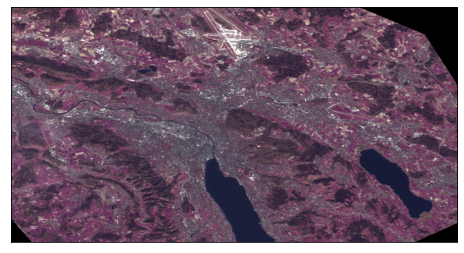

In [ ]:
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

#Visualize the labeld data 

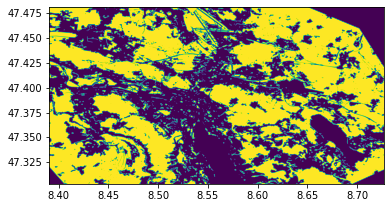

In [ ]:
y_data =rasterio.open("/content/drive/MyDrive/sat_images/places/Zurich_District_Zurich_Zurich_Switzer_8.339246_47.276434__8.77791__47.507616/labels.tif")
show(y_data)

# Data Distribution of Bands

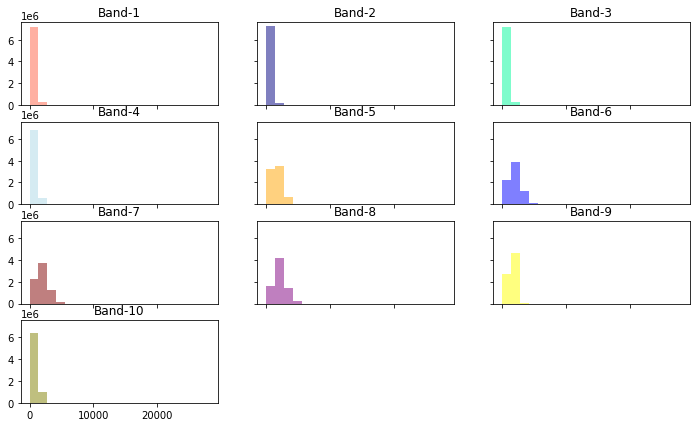

In [ ]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

ep.hist(arr_st, 
         colors = colors,
        title=[f'Band-{i}' for i in range(1,11)], 
        cols=3, 
        alpha=0.5, 
        figsize = (12,7)
        )

plt.show()

# Preprocessing

In [ ]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(1975, 3744, 10)

In [ ]:
from sklearn.preprocessing import StandardScaler

X_data = x.reshape(-1, 10)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(7394400, 10)

The labeld image of the satellite image is read using the loadmat method from the scipy.io package.


In [ ]:
y_data = loadmat('/content/drive/MyDrive/sat_images/places/Zurich_District_Zurich_Zurich_Switzer_8.339246_47.276434__8.77791__47.507616/labels (1)1622532834.mat')["M"]
y_data.shape


(1975, 3744)

# Feature Selection on the bands

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)

pca.fit(X_scaled)

data = pca.transform(X_scaled)

In [ ]:
data.shape

(7394400, 4)

In [ ]:
pca.explained_variance_ratio_

array([0.69874306, 0.23760782, 0.04363611, 0.00771173])

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.9876987175644536

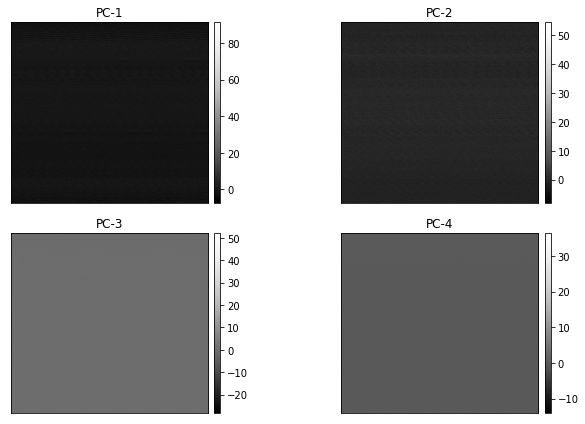

In [ ]:
ep.plot_bands(np.moveaxis(data.reshape((2600  ,2844 , data.shape[1])), -1, 0),
              cols = 2,
              figsize = (10, 6),
              title = [f'PC-{i}' for i in range(1,5)])

plt.show()

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
import pickle

X_train, X_test, y_train, y_test = train_test_split(data, y_data.ravel(), test_size=0.30, stratify = y_data.ravel())

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (5176080, 4)
X_test Shape: (2218320, 4)
y_train Shape: (5176080,)
y_test Shape:(2218320,)


#K-Nearest Neighbor Classifier (K-NNC)

Data instances of the same class should be closer in the feature space.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

filename = 'KNN_model.sav'
pickle.dump(knn, open(filename, 'wb'))

In [ ]:
knn_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=uint8)

In [ ]:
 from sklearn.metrics import mean_squared_error
 from math import sqrt

 mse = mean_squared_error(y_test, knn_pred)
 rmse = sqrt(mse)
 rmse



0.46032058142796195

In [ ]:
from sklearn.metrics import accuracy_score

print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}")

Accuracy: 78.81049623138232


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.72      0.89      0.80   1039595
           1       0.88      0.70      0.78   1178725

    accuracy                           0.79   2218320
   macro avg       0.80      0.79      0.79   2218320
weighted avg       0.81      0.79      0.79   2218320



**Plotting the Fit of the Model**




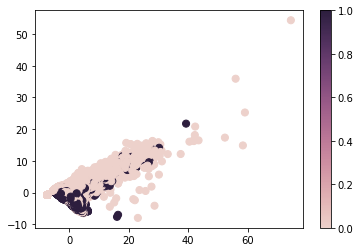

In [ ]:
 import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True)
 f, ax = plt.subplots()
points = ax.scatter(
    X_test[:, 0], X_test[:, 1], c= knn_pred, s=50, cmap=cmap
 )
 f.colorbar(points)
 plt.show()


In [ ]:
K=knn.predict(X_scaled)


In [ ]:
K.shape

(7394400,)

use c to specify that the predicted values (knn_pred) should be used as a colorbar.
each point is an abalone from the test set,The color of the point reflects the predicted age.




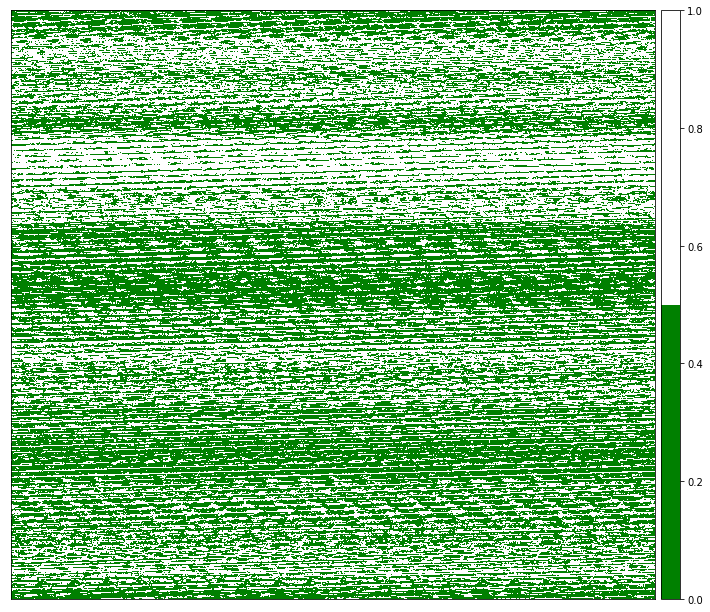

In [ ]:
# Visualize Classification Map of K-NNC

ep.plot_bands(K.reshape((2600, 2844)), 
              cmap=ListedColormap(['green', 'white']))
plt.show()



#Support Vector Machine (SVM)

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

--2021-06-02 06:44:43--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.16.29
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.16.29|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2021-06-02 06:44:44--  https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?DXjzhNLXwTgmCrPl1ToQ0mXMQe02cnrBXh9ykUCUysjmTWq-Y9fLf_UOlF4PpxuLhOl8g_mChY4PXBze253To9aMzcUE0ok

In [ ]:
!pip install thundersvm

     |████████████████████████████████| 512kB 14.2MB/s 


In [ ]:
from thundersvm import SVC

In [ ]:
model = SVC(C=100, kernel='rbf')

# Fit the model to training data
model.fit(X_train, y_train)

filename = 'SVM_model.sav'
pickle.dump(model, open(filename, 'wb'))
model

In [ ]:
svm_pred = model.predict(X_test)


In [ ]:
svm_pred

In [ ]:
# Check test set accuracy
accuracy = model.score(X_test, y_test)

print('Accuracy: {}'.format(accuracy))

Accuracy: 0.9424903486346834


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97    667092
           1       0.90      0.72      0.80    125801

    accuracy                           0.94    792893
   macro avg       0.92      0.85      0.88    792893
weighted avg       0.94      0.94      0.94    792893

